# Rayleigh Scattering

**Scott Prahl**

**April 2021**
    
*If miepython is not installed, uncomment the following cell (i.e., delete the #) and run (shift-enter)*

In [1]:
#!pip install --user miepython

In [2]:
import numpy as np
import matplotlib.pyplot as plt

try:
    import miepython.miepython_jit as miepython

except ModuleNotFoundError:
    print('miepython not installed. To install, uncomment and run the cell above.')
    print('Once installation is successful, rerun this cell again.')

## Goals for this notebook:

* Plot Rayleigh scattering
* Compare total scattering between Rayleigh and Mie
* Compare scattering functions for unpolarized light
* Compare polarized results.

## Rayleigh Scattering Functions

In [3]:
def rayleigh(m,x):
    """
    Calculate the efficiencies for a small sphere.
            
    Based on equations 5.7 - 5.9 in Bohren and Huffman

    Args:
        m: the complex index of refraction of the sphere
        x: the size parameter of the sphere

    Returns:
        qext: the total extinction efficiency
        qsca: the scattering efficiency
        qback: the backscatter efficiency
        g: the average cosine of the scattering phase function
    """
    ratio = (m**2-1)/(m**2+2)
    qsca = 8/3*x**4*abs(ratio)**2
    qext = 4*x*ratio*(1+x**2/15*ratio*(m**4+27*m**2+38)/(2*m**2+3))
    qext = abs(qext.imag + qsca)
    qback = 4*x**4*abs(ratio)**2
    g = 0
    return qext, qsca, qback, g


def rayleigh_S1_S2(m,x,mu):
    """
    Calculate the scattering amplitude functions for small spheres.

    Based on equation 5.4 in Bohren and Huffman

    The amplitude functions are normalized so that when integrated
    over all 4*pi solid angles, the integral will be qext*pi*x**2.

    The units are weird, sr**(-0.5)

    Args:
        m: the complex index of refraction of the sphere
        x: the size parameter of the sphere
        mu: the angles, cos(theta), to calculate scattering amplitudes

    Returns:
        S1, S2: the scattering amplitudes at each angle mu [sr**(-0.5)]
    """

    a1 = (2*x**3)/3 * (m**2-1)/(m**2+2)*1j
    a1 += (2*x**5)/5 * (m**2-2)*(m**2-1)/(m**2+2)**2 *1j

    s1 = (3/2)*a1*np.ones_like(mu)
    s2 = (3/2)*a1*mu
    
    ## scale so integral over all angles is single scattering albedo
    qext, qsca, qback, g = rayleigh(m,x)

    factor = np.sqrt(np.pi*qext)*x
    return s1/factor, s2/factor


def rayleigh_unpolarized(m,x,mu):
    """
    Return the unpolarized scattered intensity for small spheres.

    This is the average value for randomly polarized incident light.
    The intensity is normalized so the integral of the unpolarized 
    intensity over 4pi steradians is equal to the single scattering albedo.

    Args:
       m: the complex index of refraction of the sphere
       x: the size parameter
       mu: the cos(theta) of each direction desired

    Returns
       The intensity at each angle in the array mu.  Units [1/sr]
    """
    s1, s2 = rayleigh_S1_S2(m,x,mu)
    return (abs(s1)**2+abs(s2)**2)/2

Mie scattering describes the special case of the interaction of light passing through a non-absorbing medium with a single embedded spherical object.  The sphere itself can be non-absorbing, moderately absorbing, or perfectly absorbing.

Rayleigh scattering is a simple closed-form solution for the scattering from small spheres.

## The Rayleigh scattering phase function


Rayleigh scattering describes the elastic scattering of light by spheres that are much smaller than the wavelength of light. The intensity $I$ of the scattered radiation is given by

$$
I=I_{0}\left(\frac {1+\cos ^{2}\theta }{2R^{2}}\right)
       \left(\frac {2\pi }{\lambda }\right)^{4}
       \left(\frac {n^{2}-1}{n^{2}+2}\right)^{2}
       \left(\frac {d}{2}\right)^{6}
$$

where $I_0$ is the light intensity before the interaction with the particle, $R$ is the distance between the particle and the observer, $\theta$ is the scattering angle, $n$ is the refractive index of the particle, and $d$ is the diameter of the particle.

$$
x = \frac{\pi d}{\lambda} \qquad \rho=\frac{R}{\lambda}
$$

and thus

$$
I=\frac{I_0}{8\pi^2\rho^2} 
       \left(\frac{n^2-1}{n^2+2}\right)^{2}
       x^{4}(1+\cos^2\theta)
$$



## Compare Efficiencies with Mie Code

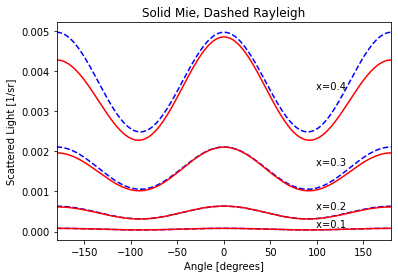

In [4]:
for x in [0.1,0.2,0.3,0.4]:

    m = 1.5-1j
    theta = np.linspace(-180,180,180)
    mu = np.cos(theta*np.pi/180)

    rscat = rayleigh_unpolarized(m,x,mu)
    mscat = miepython.i_unpolarized(m,x,mu)
    plt.plot(theta,rscat,'--b')
    plt.plot(theta,mscat,'r')
    plt.annotate('x=%.1f   '%x,(theta[-20],mscat[-20]),ha='right',va='bottom')

plt.xlim(-180,180)
plt.xlabel('Angle [degrees]')
plt.ylabel('Scattered Light [1/sr]')
plt.title('Solid Mie, Dashed Rayleigh')
plt.show()

## Polar plots for fun

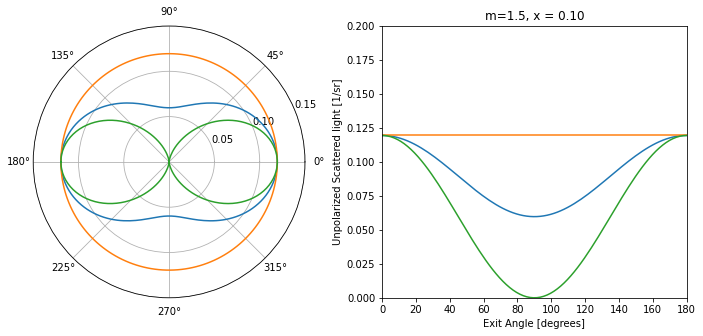

In [5]:
m = 1.5
x = 0.1
theta = np.linspace(-180,180,180)
mu = np.cos(theta/180*np.pi)
unp = rayleigh_unpolarized(m,x,mu)
s1,s2 = rayleigh_S1_S2(m,x,mu)
par = abs(s1)**2
per = abs(s2)**2

fig,ax = plt.subplots(1,2,figsize=(12,5))
ax=plt.subplot(121, projection='polar')
ax.plot(theta/180*np.pi,unp)
ax.plot(theta/180*np.pi,par)
ax.plot(theta/180*np.pi,per)

ax.set_rticks([0.05, 0.1,0.15]) 

plt.subplot(122)
#plt.plot(theta,scat)
plt.plot(theta,unp)
plt.plot(theta,par)
plt.plot(theta,per)

plt.xlabel('Exit Angle [degrees]')
plt.ylabel('Unpolarized Scattered light [1/sr]')
plt.title("m=1.5, x = %.2f"%x)

plt.ylim(0.00,0.2)
plt.xlim(0,180)

plt.show()

## Compare Rayleigh and Mie efficiencies

In [6]:
m = 1.5
x = 0.1
qext, qsca, qback, g = miepython.mie(m,x)
rext, rsca, rback, rg = rayleigh(m,x)

print('Qext        Qsca        Qback       g')
print("%.5e %.5e %.5e %.5f Mie"%(qext, qsca, qback, g))
print("%.5e %.5e %.5e %.5f Rayleigh"%(rext, rsca, rback, rg))

Qext        Qsca        Qback       g
2.30841e-05 2.30841e-05 3.44629e-05 0.00198 Mie
2.30681e-05 2.30681e-05 3.46021e-05 0.00000 Rayleigh


## Compare scattering amplitudes S1 and S2

In [7]:
m = 1.5
x = 0.1
theta = np.linspace(-180,180,19)
mu = np.cos(np.deg2rad(theta))

s1,s2 = miepython.mie_S1_S2(m,x,mu)
rs1, rs2 = rayleigh_S1_S2(m,x,mu)

# the real part of the Rayleigh scattering is always zero

print("          Mie       Rayleigh | Mie      Rayleigh")
print("  angle | S1.imag    S1.imag | S2.imag  S2.imag")
print("------------------------------------------------")
for i,angle in enumerate(theta):
    print("%7.2f | %8.5f  %8.5f | %8.5f %8.5f " % (angle,s1[i].imag,rs1[i].imag, s2[i].imag ,rs2[i].imag))


          Mie       Rayleigh | Mie      Rayleigh
  angle | S1.imag    S1.imag | S2.imag  S2.imag
------------------------------------------------
-180.00 |  0.34468   0.34562 | -0.34468 -0.34562 
-160.00 |  0.34473   0.34562 | -0.32392 -0.32477 
-140.00 |  0.34487   0.34562 | -0.26412 -0.26476 
-120.00 |  0.34509   0.34562 | -0.17242 -0.17281 
-100.00 |  0.34535   0.34562 | -0.05981 -0.06002 
 -80.00 |  0.34564   0.34562 |  0.06018  0.06002 
 -60.00 |  0.34590   0.34562 |  0.17307  0.17281 
 -40.00 |  0.34612   0.34562 |  0.26521  0.26476 
 -20.00 |  0.34626   0.34562 |  0.32540  0.32477 
   0.00 |  0.34631   0.34562 |  0.34631  0.34562 
  20.00 |  0.34626   0.34562 |  0.32540  0.32477 
  40.00 |  0.34612   0.34562 |  0.26521  0.26476 
  60.00 |  0.34590   0.34562 |  0.17307  0.17281 
  80.00 |  0.34564   0.34562 |  0.06018  0.06002 
 100.00 |  0.34535   0.34562 | -0.05981 -0.06002 
 120.00 |  0.34509   0.34562 | -0.17242 -0.17281 
 140.00 |  0.34487   0.34562 | -0.26412 -0.26476 
 160